In [1]:
import cv2
from cv2 import cvtColor
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt,gaussian
from skimage.feature import canny
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,confusion_matrix
import seaborn as sns
from scipy import ndimage
from skimage.feature import graycomatrix, graycoprops
import PIL
from matplotlib import cm
from PIL import ImageTk,Image

%matplotlib inline

In [2]:
df=pd.read_csv('/ddsm_project/data/labels.txt',sep=" ",header=None,names=['fileName','tissues','class','Severity ','X','Y','radius'])
df.drop(df.index[df['fileName'].duplicated()],inplace=True)

In [3]:
df.sample(14)

fileName tissues class Severity       X      Y  radius
210   mdb208       D  NORM       NaN    NaN    NaN     NaN
198   mdb196       F  NORM       NaN    NaN    NaN     NaN
265   mdb258       D  NORM       NaN    NaN    NaN     NaN
115   mdb115       G  ARCH         M  461.0  532.0   117.0
312   mdb305       F  NORM       NaN    NaN    NaN     NaN
329   mdb322       D  NORM       NaN    NaN    NaN     NaN
285   mdb278       G  NORM       NaN    NaN    NaN     NaN
140   mdb139       F  NORM       NaN    NaN    NaN     NaN
255   mdb249       D  CALC         M  544.0  508.0    48.0
219   mdb217       G  NORM       NaN    NaN    NaN     NaN
283   mdb276       G  NORM       NaN    NaN    NaN     NaN
193   mdb191       G  SPIC         B  594.0  516.0    41.0
135   mdb134       F  MISC         M  469.0  728.0    49.0
178   mdb176       G  NORM       NaN    NaN    NaN     NaN

In [6]:
df['fileName']

0      mdb001
1      mdb002
2      mdb003
3      mdb004
4      mdb005
        ...  
325    mdb318
326    mdb319
327    mdb320
328    mdb321
329    mdb322
Name: fileName, Length: 322, dtype: object

In [7]:
def median(img):
    medianB=cv2.medianBlur(img,11)
    return medianB

In [8]:
def equalizer(img):
    equ = cv2.equalizeHist(img)
    return equ
    

In [9]:
def roberts_filter(img):
    roberts_cross_v = np.array( [[1, 0 ],
                                [0,-1 ]] )
      
    roberts_cross_h = np.array( [[ 0, 1 ],
                                [ -1, 0 ]] )
    vertical = ndimage.convolve( img, roberts_cross_v )
    horizontal = ndimage.convolve( img, roberts_cross_h )
    edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
    edged_img=edged_img.astype(np.uint8)
    return edged_img

C:\Users\HP\AppData\Local\Temp\ipykernel_15208\3687809893.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(5,6))


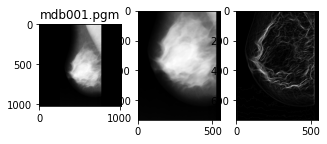

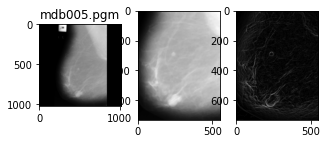

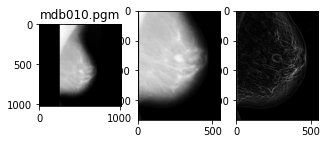

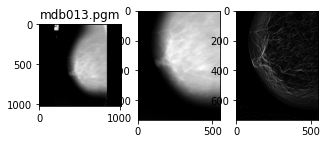

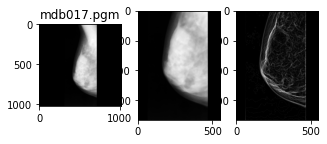

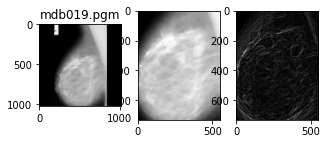

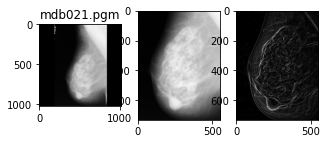

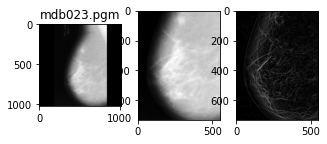

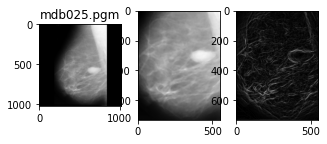

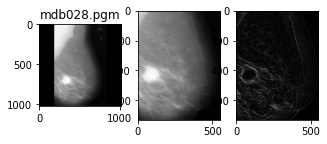

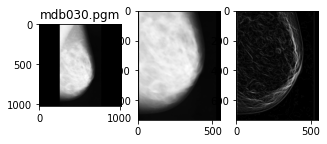

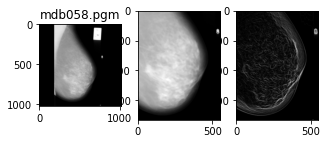

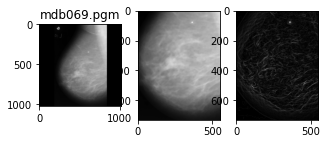

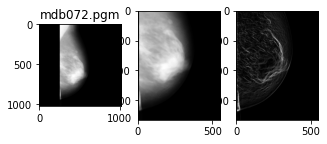

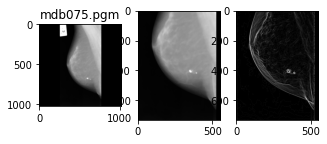

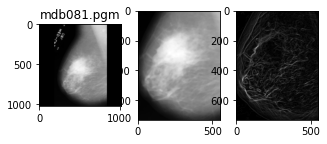

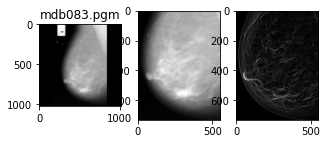

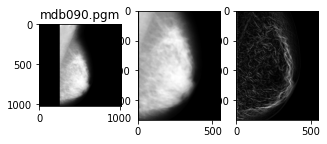

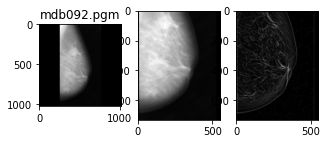

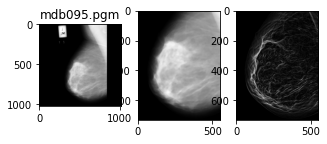

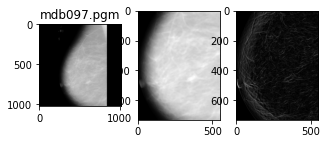

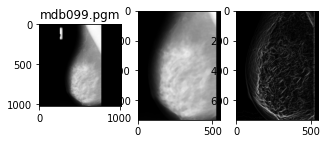

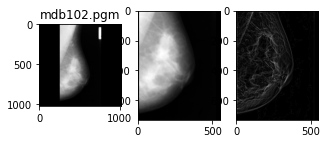

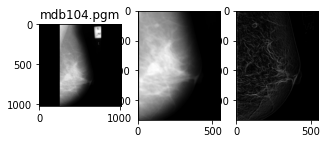

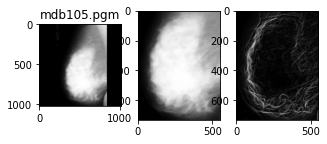

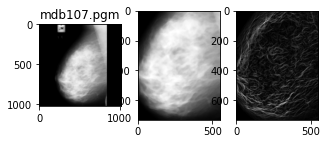

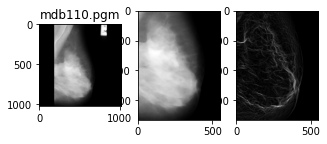

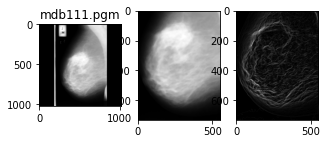

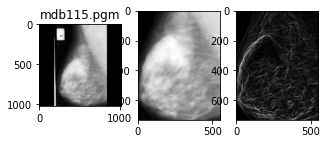

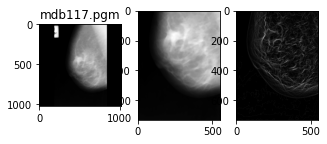

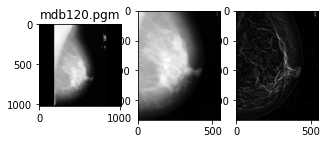

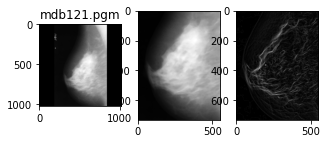

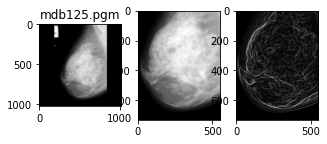

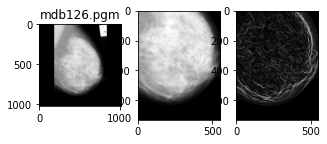

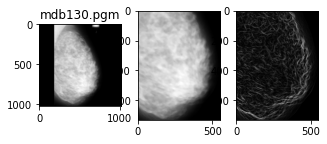

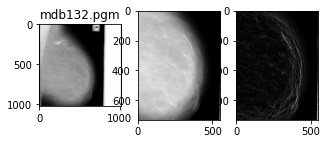

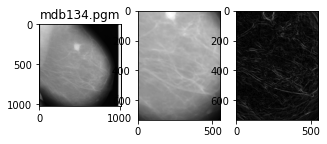

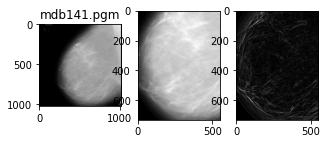

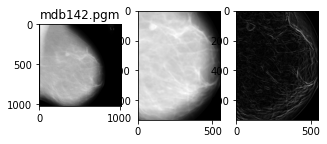

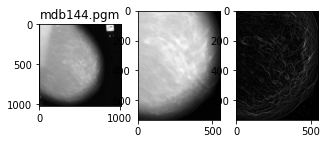

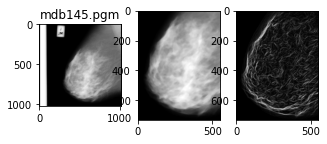

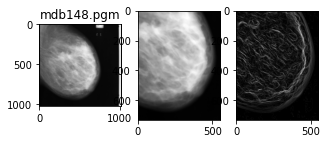

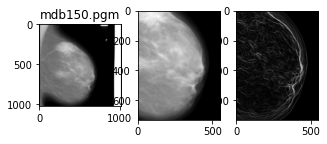

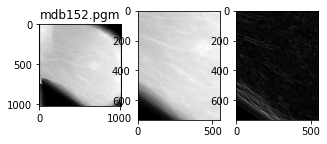

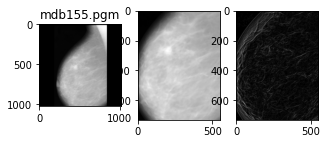

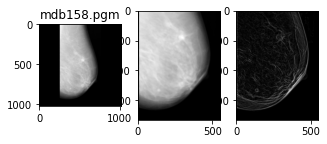

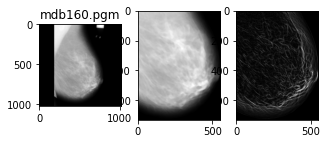

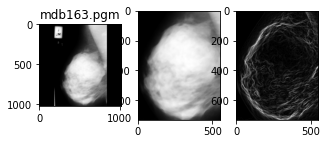

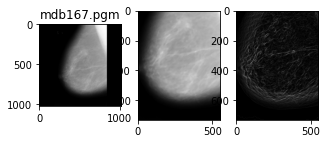

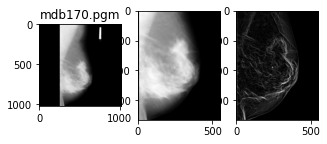

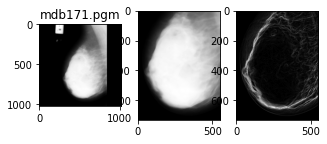

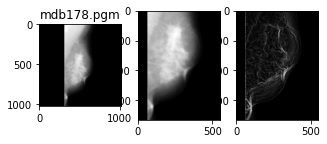

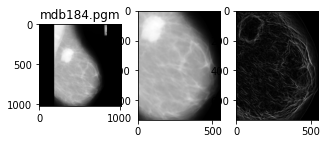

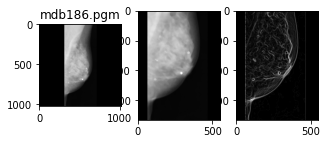

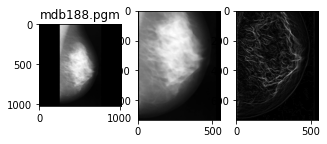

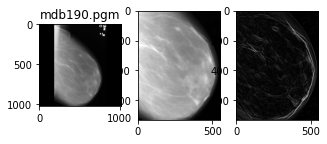

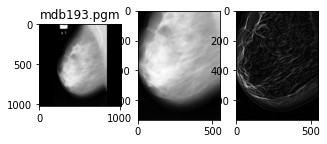

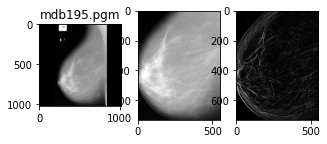

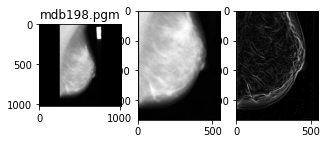

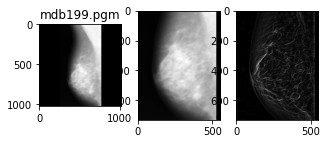

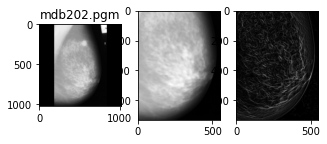

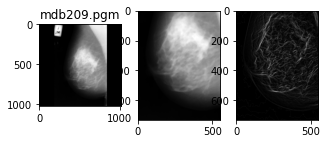

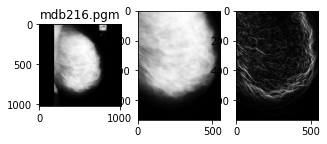

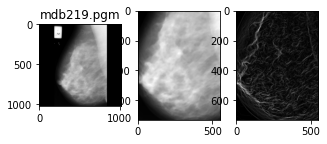

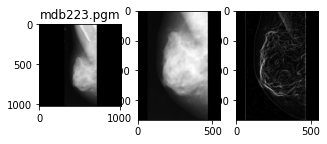

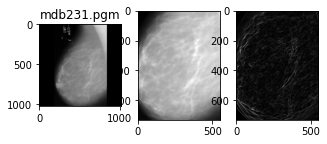

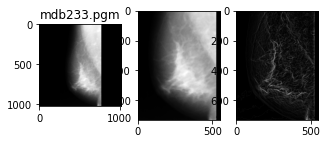

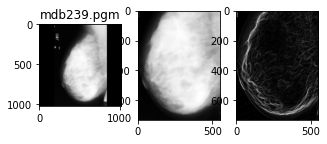

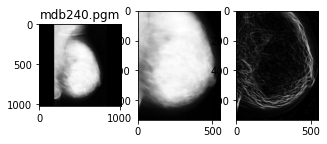

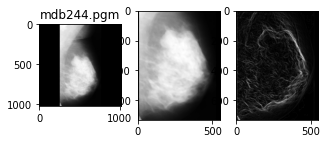

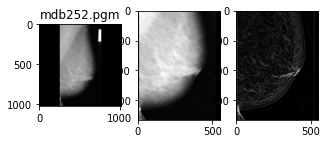

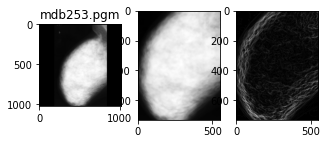

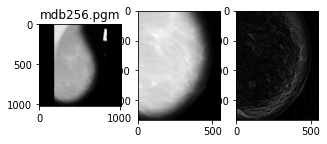

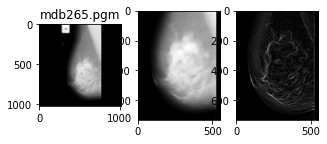

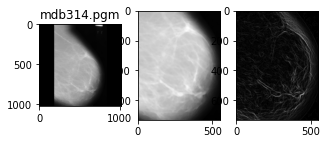

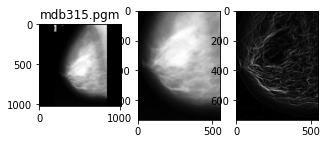

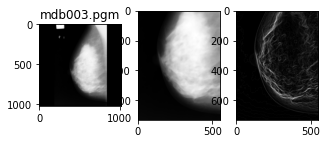

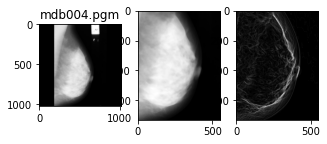

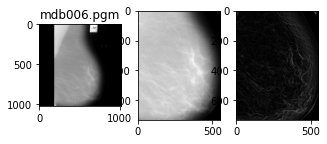

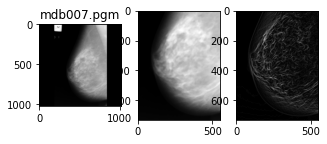

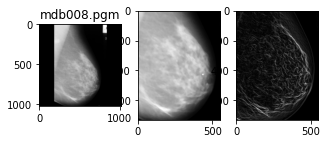

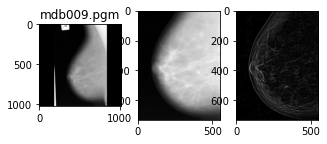

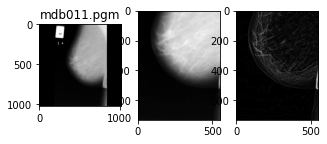

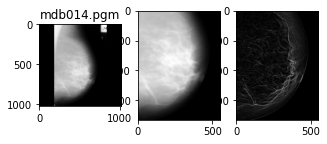

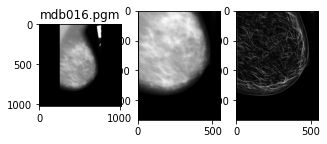

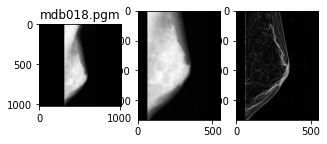

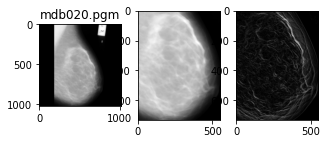

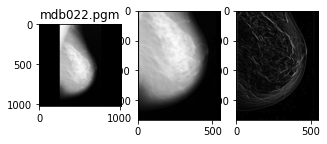

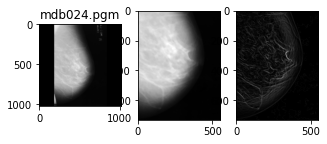

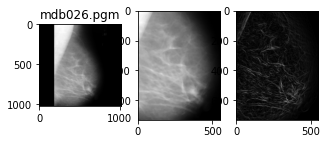

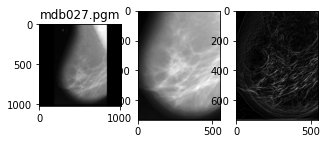

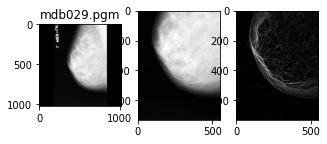

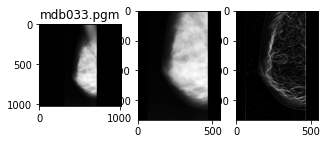

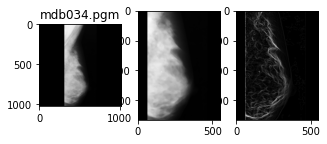

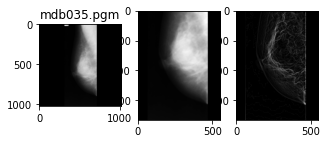

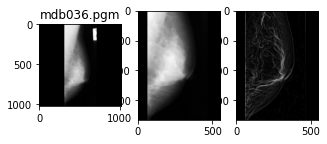

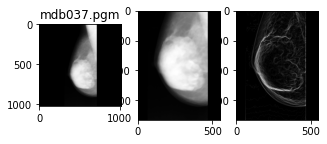

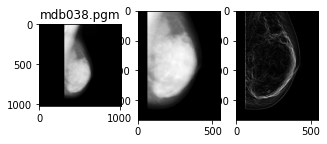

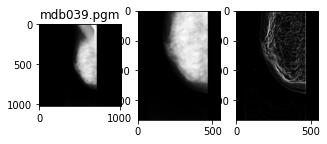

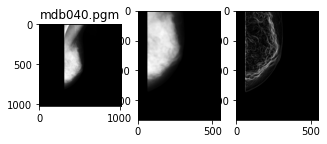

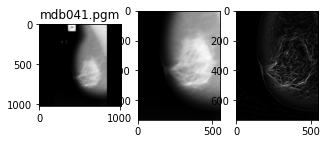

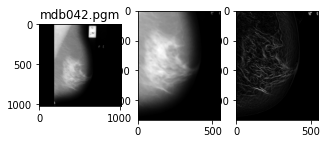

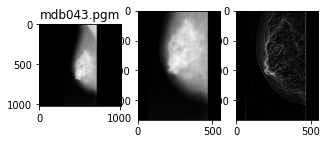

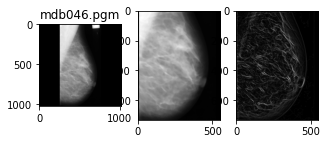

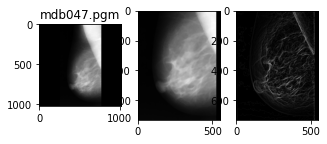

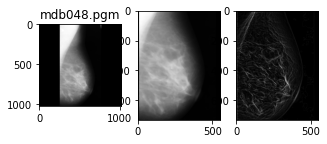

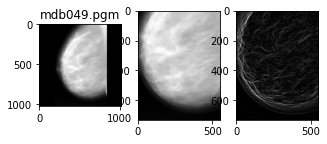

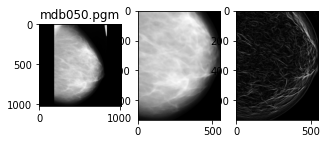

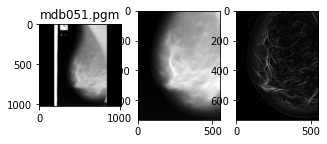

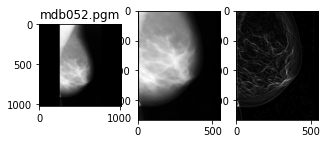

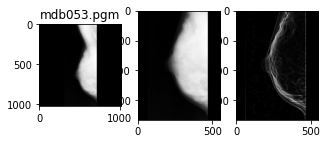

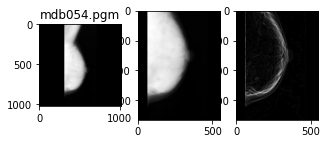

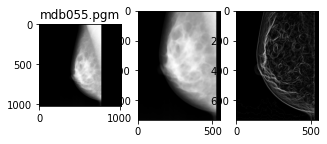

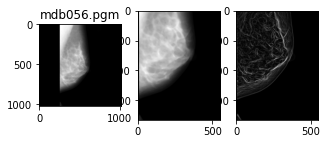

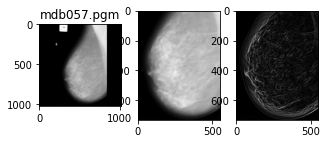

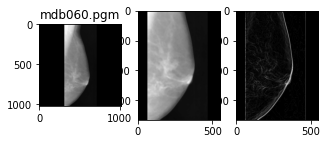

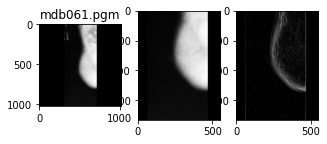

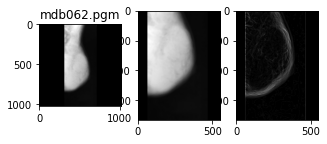

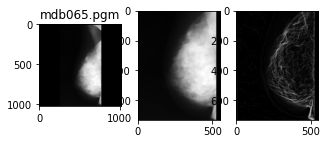

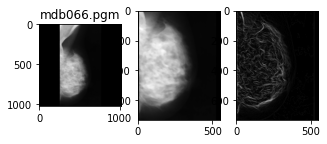

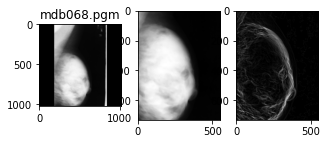

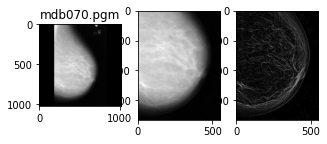

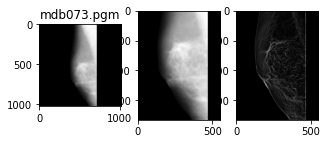

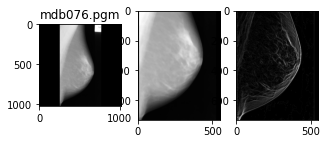

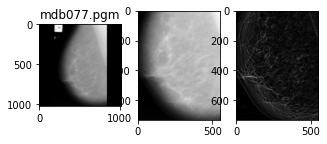

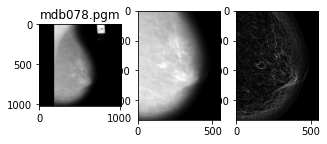

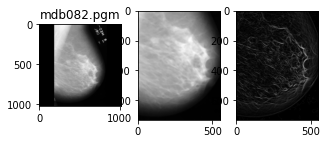

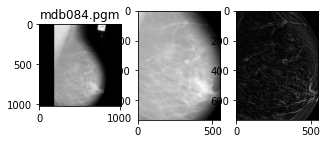

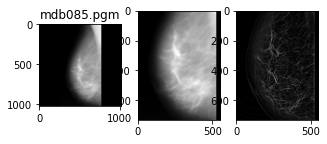

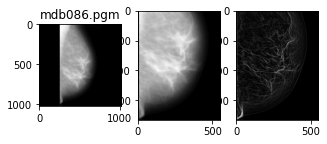

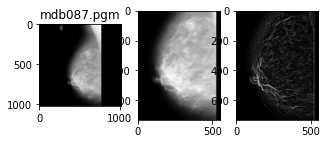

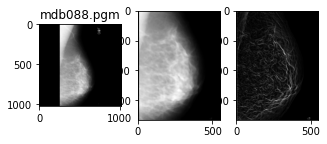

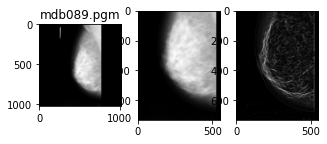

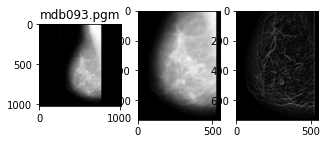

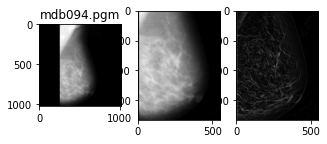

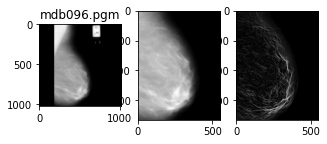

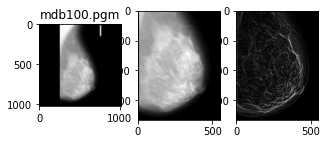

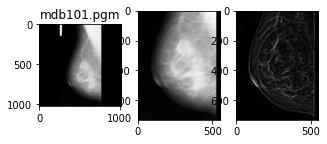

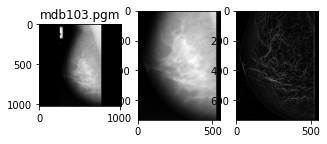

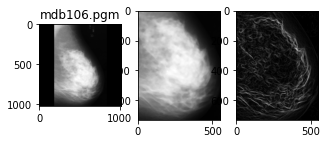

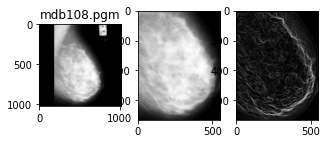

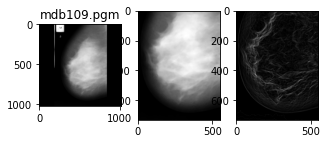

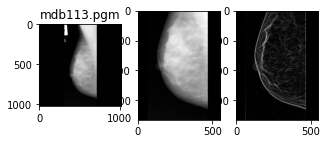

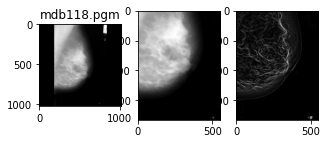

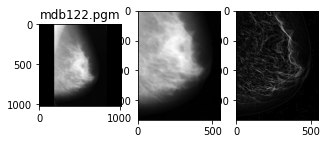

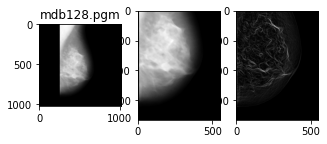

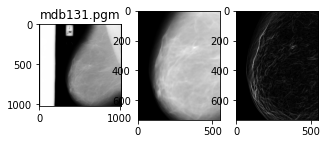

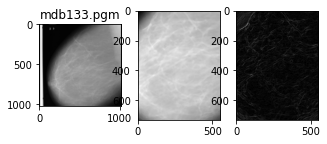

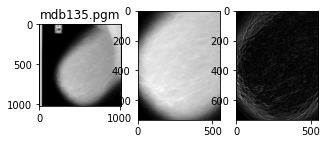

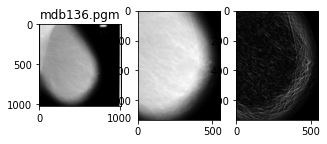

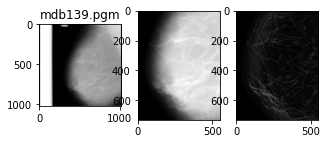

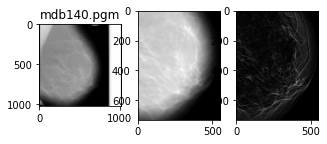

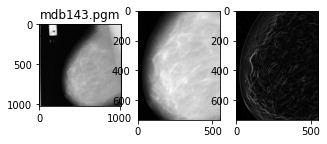

In [14]:
paths=['final_data/abnormal/','final_data/normal/']

width,height=550,731
x,y=250,276 #2
for path in paths:
    for i in os.listdir(path):
        img=plt.imread(path+i)
        img_name=i.split('.')[0]
        
#         co_odX=int(df.loc[df['fileName']==img_name,'X'].iloc[0])
#         co_ody=int(df.loc[df['fileName']==img_name,'Y'].iloc[0])
#         r=int(df.loc[df['fileName']==img_name,'radius'].iloc[0])
        
      
        #media
        medianB=median(img)
        #equalizer
        #equ = equalizer(medianB)
        #cropping
        #croped=equ[y:y+r*2, x:x+r*2]
        
        croped=medianB[y:y+height, x:x+width]
        #roberts
    
        edged_img=roberts_filter(croped)
        roberts=edged_img.copy()

        
        original_img=roberts_filter(img)
        
        #marking Image
        imgMarked= cv2.circle(original_img,(co_odX,co_ody),r,color = (255, 0, 0),thickness=2)
        ########plotting images
        fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(5,6))
        ax1.imshow(medianB,cmap='gray')
        ax2.imshow(croped,cmap='gray')
        ax3.imshow(roberts,cmap='gray')
        #ax3.imshow(original_img,cmap='gray')
        ax1.set_title(i)

In [15]:
features=['contrast','correlation','energy','homogeneity']
distances=[1,3,5]
angles=[0,np.pi/4,np.pi/2]

def GLCM_cal(): 
    width,height=550,731
    x,y=250,276 #2
    features_df=pd.DataFrame()
    paths=['final_data/abnormal/','final_data/normal/'] #,,'data/normal/'
    
    for path in paths:
        for i in os.listdir(path):
            temp=[]
            temp_dic={}
            img=plt.imread(path+i)
            #median Filter
            medianB=cv2.medianBlur(img,11)
            #Equalizer
            #equ = cv2.equalizeHist(medianB)
            #getting x,y,r
#             img_name=i.split('.')[0]
#             x=int(df.loc[df['fileName']==img_name,'X'].iloc[0])
#             y=int(df.loc[df['fileName']==img_name,'Y'].iloc[0])
#             r=int(df.loc[df['fileName']==img_name,'radius'].iloc[0])
            #croped
            croped=medianB[y:y+height, x:x+width]
            #croped=masked[y:y+r*2, x:x+r*2]
            #roberts
            
            roberts_cross_v = np.array( [[1, 0 ],
                                         [0,-1 ]] )
      
            roberts_cross_h = np.array( [[ 0, 1 ],
                                         [ -1, 0 ]] )
            vertical = ndimage.convolve(croped, roberts_cross_v )
            horizontal = ndimage.convolve(croped, roberts_cross_h )
            edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
            edged_img=edged_img.astype(np.uint8)
            ######################
        
            GLCM = graycomatrix(edged_img,distances,angles)
            for n in features:
                for j in range(0,len(angles)):
                    for k in range(0,len(distances)):
                        col_values=graycoprops(GLCM,n)[j][k]
                        col_name=n[:3]+'_'+str(int(np.degrees(angles[j])))+'_'+str(distances[k])
                        temp_dic.update({col_name:col_values})
                        
                
            if path==paths[0]:
                temp_dic.update({"type":1})
            elif path==paths[1]:
                temp_dic.update({"type":0})
            features_df=features_df.append(temp_dic,ignore_index=True)
    return features_df

In [16]:
df_features=GLCM_cal()

C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df

C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df

C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df

C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df

C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df.append(temp_dic,ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_15208\4079386966.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_df=features_df

In [17]:
df_features.tail(40)

con_0_1   con_0_3   con_0_5  con_45_1  con_45_3  con_45_5  con_90_1  \
113  0.749419  0.944527  0.445699  1.517042  1.432599  1.023636  1.920933   
114  0.683940  1.101138  0.700869  1.542967  1.630288  1.586786  2.087225   
115  1.333438  1.460117  0.340042  2.354887  2.154556  0.713157  2.850478   
116  0.851756  0.893048  0.231938  1.325409  1.220245  0.439171  1.473000   
117  0.854163  0.933673  0.269151  1.226939  1.171293  0.461216  1.345112   
118  0.980661  1.176904  0.479736  1.765101  1.723777  1.015709  2.165840   
119  0.928105  1.107318  0.538705  1.714963  1.593769  1.148836  2.129751   
120  0.578555  0.725286  0.516663  1.108514  1.015843  1.090947  1.503653   
121  0.442346  0.647965  0.503833  0.847313  0.850733  0.967255  1.096409   
122  0.784224  0.852714  0.347736  1.465534  1.301125  0.717368  1.720142   
123  1.141850  1.309372  0.487450  2.290719  2.046662  1.063074  2.814533   
124  0.441205  0.630561  0.460767  0.707005  0.743752  0.772035  0.868515   
125  0.395426  0.538596  0.402951  0.665698  0.653232  0.724461  0.823130   
126  0.517758  0.772860  0.658192  1.075820  1.062727  1.359378  1.477825   
127  0.549284  0.848841  0.666229  1.093716  1.190800  1.373322  1.473246   
128  0.879161  1.118168  0.531477  1.601127  1.607184  1.069038  1.917138   
129  0.860453  1.051808  0.516112  1.687228  1.570327  1.031226  2.061206   
130  0.906735  1.212888  0.672555  1.801829  1.843999  1.455502  2.287499   
131  0.880143  1.091941  0.589427  1.703934  1.630230  1.262560  2.124319   
132  0.837264  1.080827  0.551843  1.601913  1.636834  1.196084  2.003464   
133  0.807896  1.082816  0.540762  1.546543  1.624423  1.068124  1.859918   
134  0.849813  1.003084  0.536374  1.551705  1.440432  1.032727  1.866449   
135  0.517935  0.698994  0.525781  1.103922  1.052930  1.184508  1.512072   
136  1.070450  1.307700  0.723260  2.273343  2.059758  1.644520  2.905097   
137  0.871132  1.084315  0.526020  1.729548  1.663052  1.117527  2.148672   
138  0.810149  0.991983  0.504730  1.368654  1.370160  0.936618  1.610894   
139  0.670078  0.988021  0.804971  1.421361  1.434752  1.791858  2.002257   
140  0.799197  1.068017  0.870902  1.774957  1.608523  2.052300  2.510082   
141  0.472871  0.726494  0.498359  0.827801  0.908932  0.900762  1.056007   
142  0.830611  0.989173  0.453507  1.721881  1.533528  1.006064  2.269195   
143  0.452914  0.688380  0.521811  0.994481  1.005672  1.162093  1.394877   
144  0.524291  0.709397  0.568523  1.050688  0.930146  1.195202  1.416750   
145  0.704133  0.839322  0.439534  1.317071  1.213058  0.864755  1.586431   
146  0.622101  0.839579  0.453557  1.278680  1.167042  0.893901  1.580063   
147  0.397395  0.673306  0.490194  0.696406  0.795242  0.804226  0.851271   
148  0.433241  0.681625  0.485636  0.751459  0.795320  0.820564  0.916103   
149  0.431340  0.578634  0.421644  0.701078  0.688595  0.711926  0.838678   
150  0.425671  0.590256  0.434608  0.709154  0.692369  0.798729  0.892120   
151  0.454100  0.610071  0.430115  0.802437  0.758821  0.787388  0.998873   
152  0.543049  0.770167  0.468986  1.043393  1.004058  0.897725  1.358832   

     con_90_3  con_90_5   cor_0_1  ...   hom_0_1   hom_0_3   hom_0_5  \
113  1.987827  1.424681  0.820693  ...  0.868920  0.844611  0.879872   
114  2.302639  2.142324  0.832992  ...  0.790468  0.735028  0.787588   
115  2.903699  1.010321  0.668637  ...  0.866396  0.842138  0.893814   
116  1.403719  0.550994  0.763205  ...  0.898969  0.886174  0.923755   
117  1.327763  0.556617  0.712313  ...  0.879436  0.856715  0.906872   
118  2.277829  1.350058  0.791555  ...  0.841663  0.813250  0.869193   
119  2.140252  1.535244  0.777233  ...  0.835028  0.802624  0.844212   
120  1.508896  1.450644  0.893036  ...  0.823486  0.800826  0.839237   
121  1.162502  1.211926  0.810319  ...  0.828261  0.783780  0.815636   
122  1.600355  0.953499  0.743803  ...  0.863669  0.851733  0.886717   
123  2.755496  1.467358  0.756993  ...  0.834258  0.8044

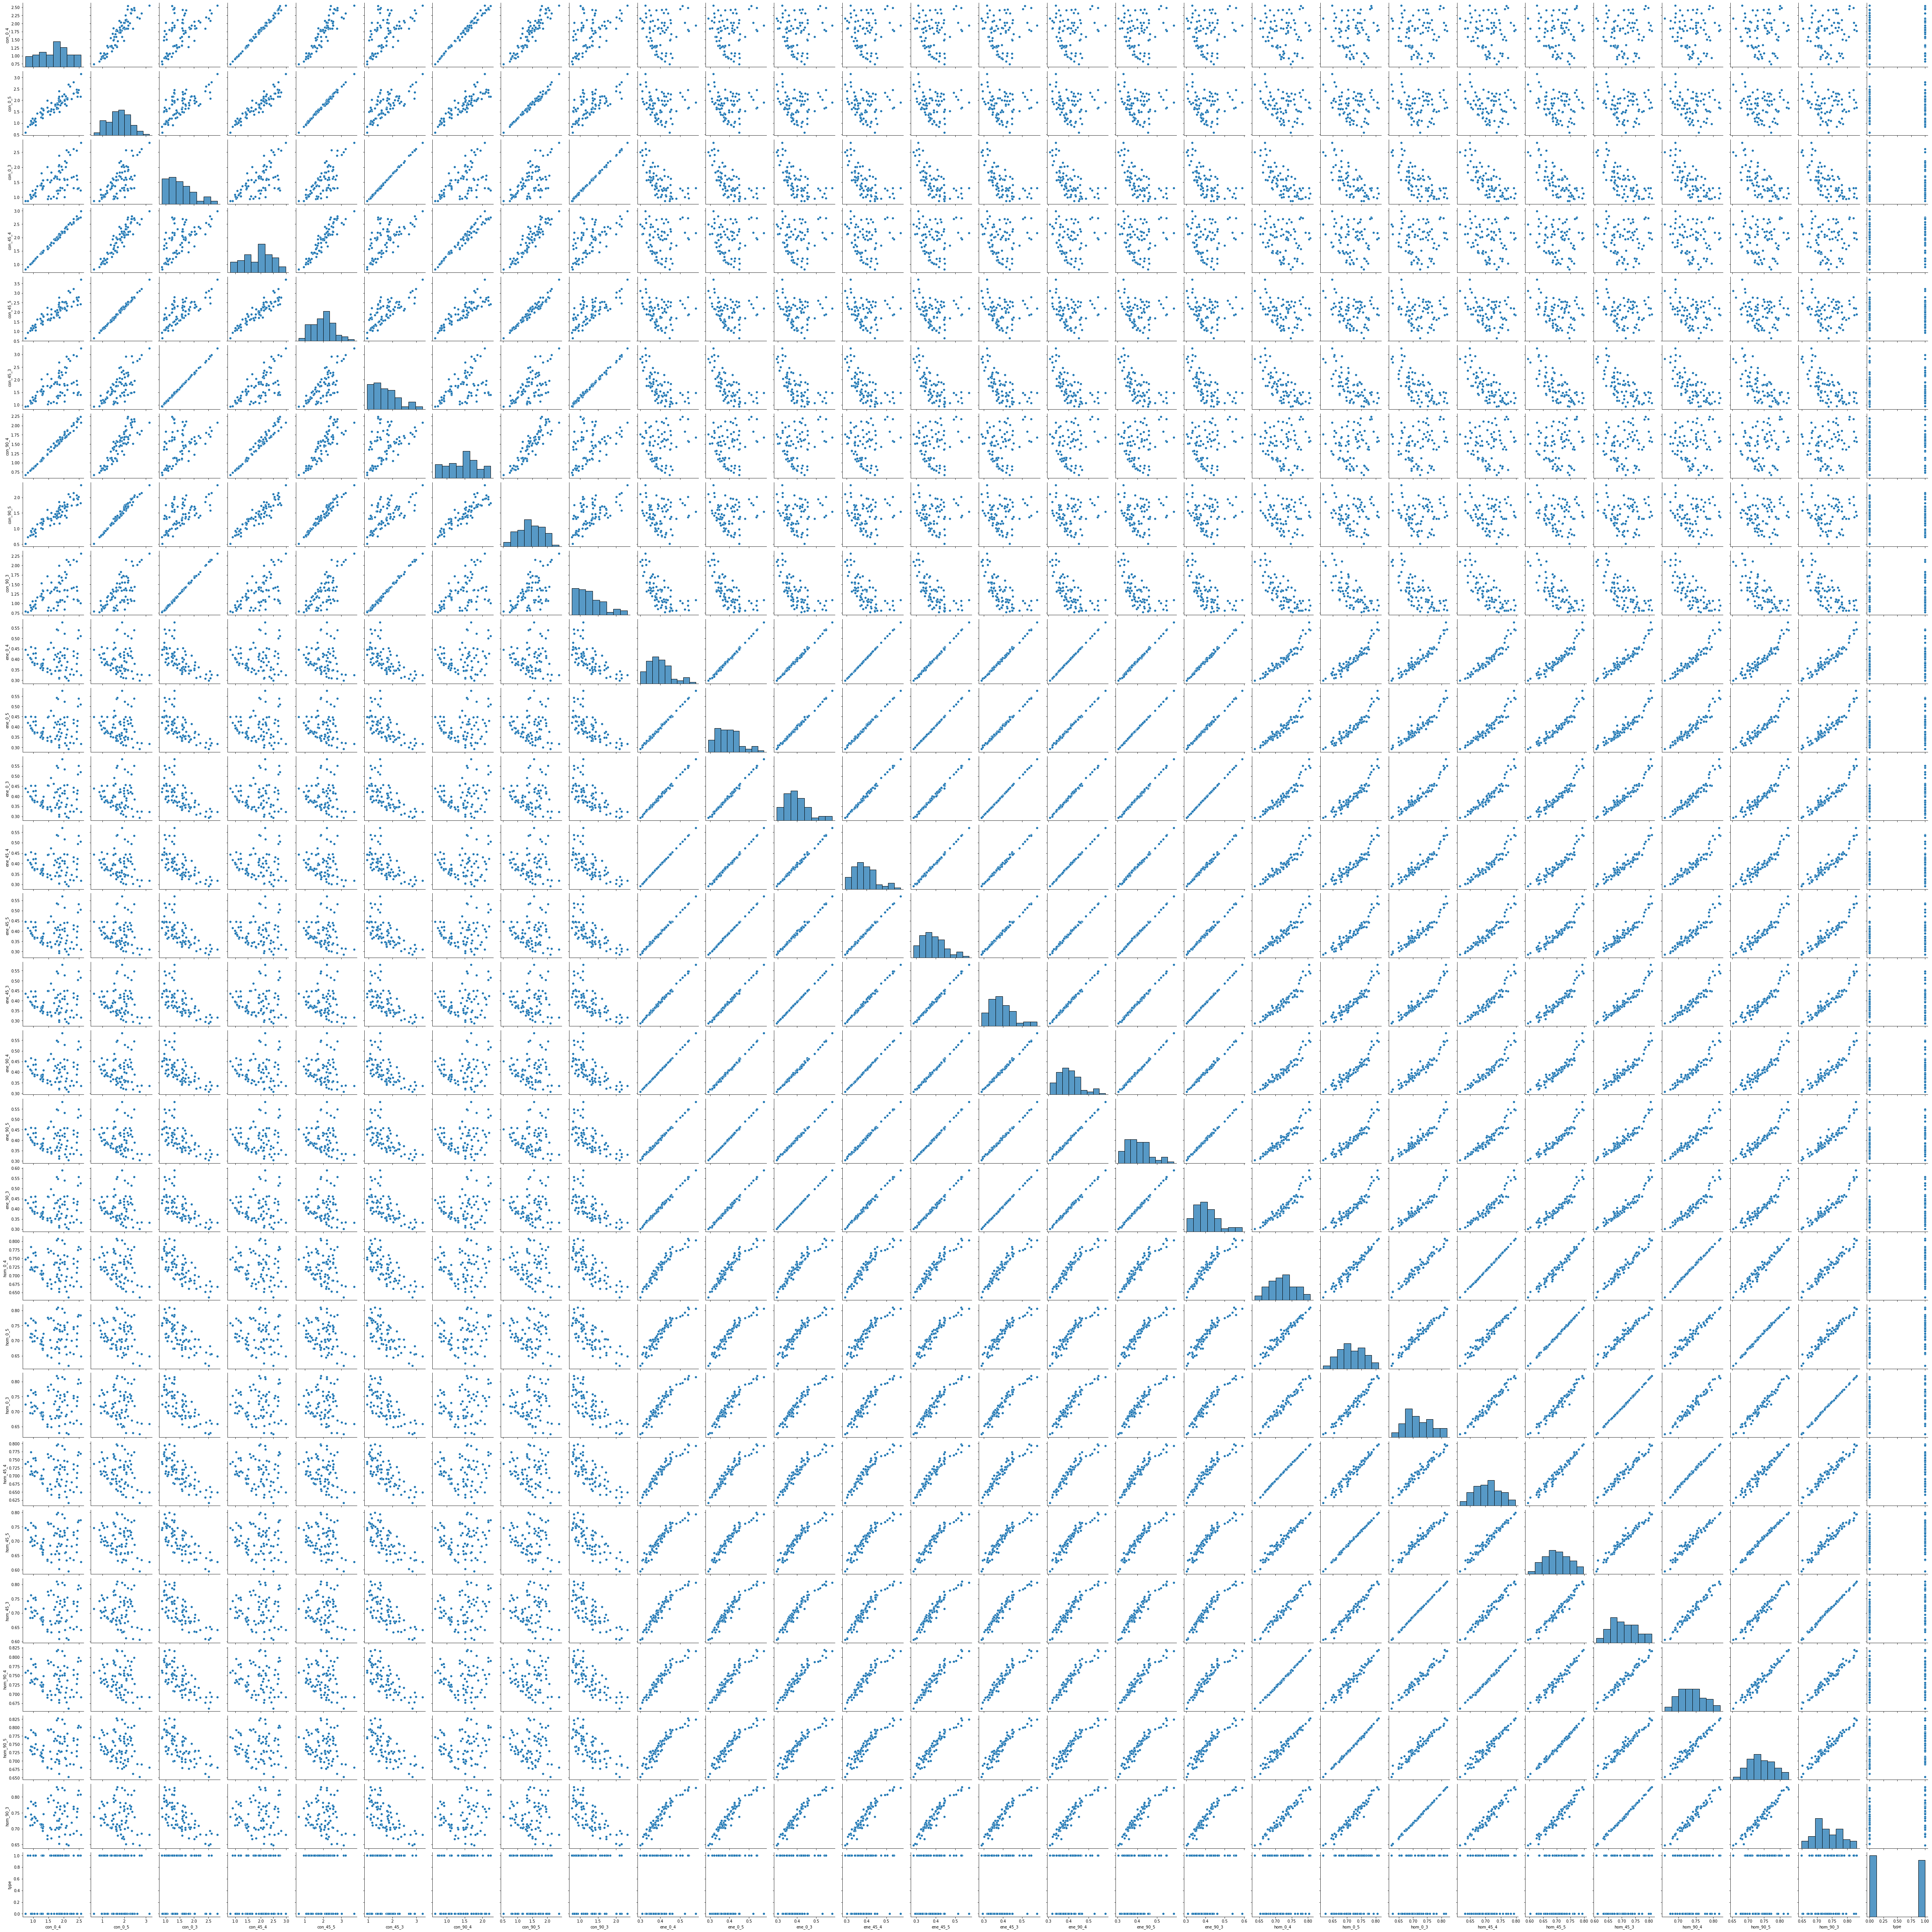

In [134]:
sns.pairplot(df_features)

In [18]:
df_features.columns

Index(['con_0_1', 'con_0_3', 'con_0_5', 'con_45_1', 'con_45_3', 'con_45_5',
       'con_90_1', 'con_90_3', 'con_90_5', 'cor_0_1', 'cor_0_3', 'cor_0_5',
       'cor_45_1', 'cor_45_3', 'cor_45_5', 'cor_90_1', 'cor_90_3', 'cor_90_5',
       'ene_0_1', 'ene_0_3', 'ene_0_5', 'ene_45_1', 'ene_45_3', 'ene_45_5',
       'ene_90_1', 'ene_90_3', 'ene_90_5', 'hom_0_1', 'hom_0_3', 'hom_0_5',
       'hom_45_1', 'hom_45_3', 'hom_45_5', 'hom_90_1', 'hom_90_3', 'hom_90_5',
       'type'],
      dtype='object')

In [19]:
df_features.shape

(153, 37)

In [20]:
df_features.mean()

con_0_1     0.705065
con_0_3     0.935950
con_0_5     0.557409
con_45_1    1.376926
con_45_3    1.339190
con_45_5    1.166313
con_90_1    1.774943
con_90_3    1.841501
con_90_5    1.545121
cor_0_1     0.796855
cor_0_3     0.726949
cor_0_5     0.832264
cor_45_1    0.610356
cor_45_3    0.618247
cor_45_5    0.659077
cor_90_1    0.501582
cor_90_3    0.482212
cor_90_5    0.554425
ene_0_1     0.463873
ene_0_3     0.441839
ene_0_5     0.466869
ene_45_1    0.434848
ene_45_3    0.434778
ene_45_5    0.435212
ene_90_1    0.422080
ene_90_3    0.419109
ene_90_5    0.423366
hom_0_1     0.819500
hom_0_3     0.780310
hom_0_5     0.823603
hom_45_1    0.755936
hom_45_3    0.758639
hom_45_5    0.755063
hom_90_1    0.727662
hom_90_3    0.722539
hom_90_5    0.727262
type        0.496732
dtype: float64

In [21]:
df_features.std()

con_0_1     0.209224
con_0_3     0.223444
con_0_5     0.138647
con_45_1    0.412692
con_45_3    0.382348
con_45_5    0.359775
con_90_1    0.536332
con_90_3    0.560359
con_90_5    0.512151
cor_0_1     0.054386
cor_0_3     0.072950
cor_0_5     0.062973
cor_45_1    0.083060
cor_45_3    0.087784
cor_45_5    0.109112
cor_90_1    0.092208
cor_90_3    0.102593
cor_90_5    0.131941
ene_0_1     0.076889
ene_0_3     0.081166
ene_0_5     0.080978
ene_45_1    0.081467
ene_45_3    0.082503
ene_45_5    0.085417
ene_90_1    0.082870
ene_90_3    0.084084
ene_90_5    0.087082
hom_0_1     0.031001
hom_0_3     0.042248
hom_0_5     0.038968
hom_45_1    0.043607
hom_45_3    0.046046
hom_45_5    0.051579
hom_90_1    0.049487
hom_90_3    0.053246
hom_90_5    0.057057
type        0.501631
dtype: float64

In [22]:
df_features.describe()

con_0_1     con_0_3     con_0_5    con_45_1    con_45_3    con_45_5  \
count  153.000000  153.000000  153.000000  153.000000  153.000000  153.000000   
mean     0.705065    0.935950    0.557409    1.376926    1.339190    1.166313   
std      0.209224    0.223444    0.138647    0.412692    0.382348    0.359775   
min      0.363828    0.439656    0.231938    0.665698    0.519915    0.439171   
25%      0.525639    0.766200    0.465499    1.050688    1.019292    0.895984   
50%      0.695990    0.934878    0.526623    1.435193    1.361812    1.087418   
75%      0.837264    1.084315    0.648628    1.670615    1.606005    1.353631   
max      1.333438    1.532677    0.980159    2.354887    2.395400    2.306731   

         con_90_1    con_90_3    con_90_5     cor_0_1  ...     hom_0_1  \
count  153.000000  153.000000  153.000000  153.000000  ...  153.000000   
mean     1.774943    1.841501    1.545121    0.796855  ...    0.819500   
std      0.536332    0.560359    0.512151    0.054386  ...    0.031001   
min      0.806659    0.649810    0.550994    0.663083  ...    0.754353   
25%      1.402001    1.425730    1.162019    0.754845  ...    0.797072   
50%      1.824988    1.852402    1.447032    0.805201  ...    0.817047   
75%      2.129751    2.188410    1.804418    0.842810  ...    0.838718   
max      2.986767    3.705640    3.249296    0.898028  ...    0.915368   

          hom_0_3     hom_0_5    hom_45_1    hom_45_3    hom_45_5    hom_90_1  \
count  153.000000  153.000000  153.000000  153.000000  153.000000  153.000000   
mean     0.780310    0.823603    0.755936    0.758639    0.755063    0.727662   
std      0.042248    0.038968    0.043607    0.046046    0.051579    0.049487   
min      0.693718    0.748940    0.661474    0.652419    0.647897    0.616407   
25%      0.747493    0.791250    0.724530    0.727283    0.713631    0.690989   
50%      0.779132    0.824531    0.754238    0.758909    0.756191    0.725338   
75%      0.807579    0.844910    0.782130    0.786734    0.784769    0.758726   
max      0.902302    0.928360    0.887327    0.891546    0.897037    0.871995   

         hom_90_3    hom_90_5        type  
count  153.000000  153.000000  153.000000  
mean     0.722539    0.727262    0.496732  
std      0.053246    0.057057    0.501631  
min      0.594725    0.606297    0.000000  
25%      0.685087    0.683550    0.000000  
50%      0.724114    0.728037    0.000000  
75%      0.754921    0.761022    1.000000  
max      0.871680    0.883411    1.000000  

[8 rows x 37 columns]

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
df_features['type'].value_counts()

0.0    77
1.0    76
Name: type, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

In [30]:
# for i in range(0,78):

#     X_train,X_test,y_train,y_test = train_test_split(df_features.iloc[:,:-1],df_features.iloc[:,-1:],test_size=0.1,random_state=i)
#     classifier=LogisticRegression(max_iter=1000)
#     classifier.fit(df_features.iloc[:,:-1].values,df_features.iloc[:,-1:].values.ravel())
#     y_pred=classifier.predict(X_test)
#     print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#     print("F1:",f1_score(y_test,y_pred,average=None))
#     print("Confusion: \n",confusion_matrix(y_test,y_pred))
#     print(">>>>>>>>>>>>>>{}>>>>>>>>>>>>>>>>>>>>>".format(i))

In [32]:
from sklearn import metrics
from sklearn.metrics import f1_score

X_train,X_test,y_train,y_test = train_test_split(df_features.iloc[:,:-1],df_features.iloc[:,-1:],test_size=0.1,random_state=47)
classifier=LogisticRegression(max_iter=1000)
classifier.fit(df_features.iloc[:,:-1].values,df_features.iloc[:,-1:].values.ravel())
y_pred=classifier.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",f1_score(y_test,y_pred,average=None))
print("Confusion: \n",confusion_matrix(y_test,y_pred))

Accuracy: 0.875
F1: [0.85714286 0.88888889]
Confusion: 
 [[6 1]
 [1 8]]


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [34]:
df_temp=df_features.iloc[:,:-1]

In [ ]:
cross valid > valid B , Valid M 

In [35]:
for i in range(0,41):
    img=np.reshape(list(df_temp.iloc[i].values),(-1,36))
    print(classifier.predict(img))

[1.]
[0.]
[0.]
[0.]
[0.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
[0.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]


In [36]:
for i in range(40,79):
    img=np.reshape(list(df_temp.iloc[i].values),(-1,36))
    print(classifier.predict(img))

[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[0.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.]
[0.]
[1.]
[1.]
[0.]
[0.]
[0.]


In [37]:
import pickle

In [39]:
pickle.dump(classifier,open("cancerdetection2.pkl",'wb'))

##### OK

In [123]:
import statsmodels.api as sm

In [127]:
y=df_features.iloc[:,-1:]
y=df_features.iloc[:,:-1]

In [128]:
result = sm.OLS(y,X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                   type   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.529
Method:                 Least Squares   F-statistic:                              3.460
Date:                Sun, 10 Jul 2022   Prob (F-statistic):                    6.63e-05
Time:                        03:42:59   Log-Likelihood:                         -29.464
No. Observations:                  79   AIC:                                      130.9
Df Residuals:                      43   BIC:                                      216.2
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [106]:
X_train,X_test,y_train,y_test=train_test_split(df_features.iloc[:,:-1],df_features.iloc[:,-1:],test_size=0.1)

In [107]:
from sklearn.preprocessing import StandardScaler

In [108]:
normalize= StandardScaler()

In [109]:
X_train=normalize.fit_transform(X_train)
X_test=normalize.transform(X_test)

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
logistic = LogisticRegression(penalty='l2',max_iter=1000)

In [112]:
logistic.fit(X_train,np.array(y_train).ravel())

LogisticRegression(max_iter=1000)

In [113]:
y_pred=logistic.predict(X_test)

In [114]:
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix

In [115]:
confusion_matrix(y_test,y_pred)

array([[2, 2],
       [1, 3]], dtype=int64)

In [116]:
f1_score(y_test,y_pred)

0.6666666666666665